In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import re


In [ ]:
# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [ ]:
# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Input, concatenate
from keras.models import Model

In [ ]:
# Number of labels: joy, sadness, fear, anger, surprise, neutral, disgust, shame, guilt
num_classes = 9

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words)
max_seq_len = 500

class_names = ['joy', 'sadness', 'fear', 'anger', 'surprise', 'neutral', 'disgust', 'shame', 'guilt']


In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/NLP_PROJECT/Train.csv', encoding='utf-8')
data_test = pd.read_csv('/content/drive/MyDrive/NLP_PROJECT/Test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

In [ ]:
# Function to clean text
def clean_text(data):
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)

    return data

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# Function to perform POS tagging
def pos_tagging(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return pos_tags

# Clean and perform POS tagging on the text data
X_train_clean = [clean_text(text) for text in X_train]
X_test_clean = [clean_text(text) for text in X_test]

X_train_pos = [pos_tagging(text) for text in X_train_clean]
X_test_pos = [pos_tagging(text) for text in X_test_clean]

# Combine text and POS tags
X_train_combined = [' '.join([word + '_' + tag for word, tag in pos_tags]) for pos_tags in X_train_pos]
X_test_combined = [' '.join([word + '_' + tag for word, tag in pos_tags]) for pos_tags in X_test_pos]

In [ ]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_combined)

sequence_train = tokenizer.texts_to_sequences(X_train_combined)
sequence_test = tokenizer.texts_to_sequences(X_test_combined)

index_of_words = tokenizer.word_index
vocab_size = len(index_of_words) + 1

In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen=max_seq_len)
X_test_pad = pad_sequences(sequence_test, maxlen=max_seq_len)


In [ ]:
# Encoding labels
encoding = {
    'joy': 0, 'sadness': 1, 'fear': 2, 'anger': 3,
    'surprise': 4, 'neutral': 5, 'disgust': 6, 'shame': 7, 'guilt': 8
}
y_train = [encoding[x] for x in y_train]
y_test = [encoding[x] for x in y_test]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
# Function to create embedding matrix
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
# Load pre-trained word embeddings
fname = '/content/drive/MyDrive/NLP_PROJECT/embeddings/wiki-news-300d-1M.vec'
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)

In [ ]:
# Model architecture
input_text = Input(shape=(max_seq_len,))
embedding_layer = Embedding(vocab_size, embed_num_dims, input_length=max_seq_len,
                            weights=[embedd_matrix], trainable=False)(input_text)
lstm_layer = Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))(embedding_layer)

In [ ]:
# POS tags input
input_pos = Input(shape=(max_seq_len,))
dense_layer_pos = Dense(64, activation='relu')(input_pos)

# Concatenate text and POS features
concatenated = concatenate([lstm_layer, dense_layer_pos])
output = Dense(num_classes, activation='softmax')(concatenated)

In [ ]:
model = Model(inputs=[input_text, input_pos], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 500, 300)             7909500   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 256)                  439296    ['embedding[0][0]']           
 al)                                                                                          

In [ ]:
# Training
batch_size = 128
epochs = 15
hist = model.fit([X_train_pad, X_train_pad], y_train, batch_size=batch_size, epochs=epochs,
                 validation_data=([X_test_pad, X_test_pad], y_test))


Epoch 1/15
245/245 [==============================] - 761s 3s/step - loss: 92.0174 - accuracy: 0.2004 - val_loss: 39.9786 - val_accuracy: 0.2475
Epoch 2/15
245/245 [==============================] - 711s 3s/step - loss: 27.8186 - accuracy: 0.2270 - val_loss: 21.3905 - val_accuracy: 0.2019
Epoch 3/15
245/245 [==============================] - 715s 3s/step - loss: 14.2374 - accuracy: 0.2555 - val_loss: 12.2833 - val_accuracy: 0.2758
Epoch 4/15
245/245 [==============================] - 715s 3s/step - loss: 8.3711 - accuracy: 0.3159 - val_loss: 8.1961 - val_accuracy: 0.3594
Epoch 5/15
245/245 [==============================] - 711s 3s/step - loss: 5.3845 - accuracy: 0.3964 - val_loss: 5.3643 - val_accuracy: 0.4217
Epoch 6/15
245/245 [==============================] - 716s 3s/step - loss: 3.8626 - accuracy: 0.4518 - val_loss: 4.2116 - val_accuracy: 0.4570
Epoch 7/15
245/245 [==============================] - 712s 3s/step - loss: 3.1339 - accuracy: 0.4819 - val_loss: 3.2692 - val_accuracy: 

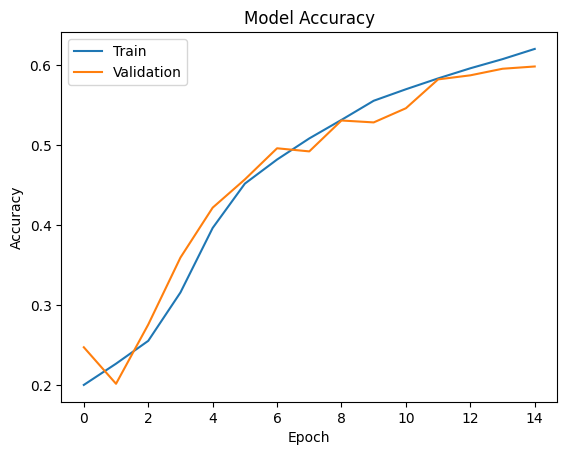

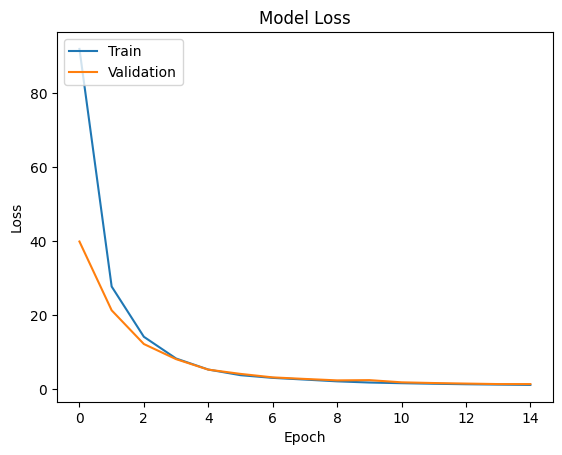

In [ ]:
# Evaluation
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Predictions
predictions = model.predict([X_test_pad, X_test_pad])
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

419/419 [==============================] - 111s 264ms/step


In [ ]:
# Evaluation metrics
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("F1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))


Accuracy: 59.80%
F1 Score: 59.80


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# Example prediction
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))


Message: apparently im getting my wisdom teeth out Friday? 
Predicted: surprise


In [ ]:
# Test a new message
message = ['delivery was hour late and my pizza was cold!']
seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

In [ ]:
pred = model.predict([padded, padded])
print('Message: ' + str(message))
print('Predicted: {} '.format(class_names[np.argmax(pred)]))

1/1 [==============================] - 0s 277ms/step
Message: ['delivery was hour late and my pizza was cold!']
Predicted: joy 


In [ ]:
# Save the model
model.save('/content/drive/MyDrive/NLP_PROJECT/LSTMpos.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
